# Pronóstico adaptativo

## Descripción del problema real
Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos
La carpeta datos/precios/ contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles
En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos
Usted debe:

Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.
Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.
Generar el pronóstico para los precios de los próximos siete días.
Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.
Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.
Determinar los valores óptimos de la tasa de aprendizaje y el momentum

In [1]:
from IPython.display import display, HTML
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
import tensorflow as tf
import numpy as np


from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn import metrics


from keras import optimizers
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

Using TensorFlow backend.


### Lectura de archivos en Disco

In [2]:
files_names = []
for filename in glob.glob("datos/precios/*"):
    files_names.append(filename)

In [3]:
files_names.sort()
files_names[0:5]

['datos/precios/Precio_Bolsa_Nacional_($kwh)_1995.xlsx',
 'datos/precios/Precio_Bolsa_Nacional_($kwh)_1996.xlsx',
 'datos/precios/Precio_Bolsa_Nacional_($kwh)_1997.xlsx',
 'datos/precios/Precio_Bolsa_Nacional_($kwh)_1998.xlsx',
 'datos/precios/Precio_Bolsa_Nacional_($kwh)_1999.xlsx']

### Lectura de los Datos

In [5]:
precio_final = pd.read_excel(files_names[0],skiprows = 3)

In [6]:
for i in range(1,len(files_names)):    
    cont = 0
    
    while(True): 
        
        precio_i = pd.read_excel(files_names[i],skiprows = cont).iloc[:,0:25]  
        
        if precio_i.columns[0] == 'Fecha':
            break
        elif cont >= 15:
            break
        else:
            cont+=1

    precio_final = pd.concat([precio_final,precio_i],ignore_index=True,axis=0) 

In [7]:
for i in range(precio_final.shape[0]):
    if type(precio_final.iloc[i,0]) != str:
        print(precio_final.iloc[i,0])
        print(type(precio_final.iloc[i,0]))
        break

1996-02-01 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [8]:
precio_final["Fecha"] = pd.to_datetime(precio_final["Fecha"])

In [9]:
precio_final = precio_final.sort_values(by=['Fecha'])

In [10]:
serie = pd.concat([precio_final["Fecha"],precio_final.mean(axis=1)],axis=1)

/Users/sebastianparra/Codigos/Udemy/ENV/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


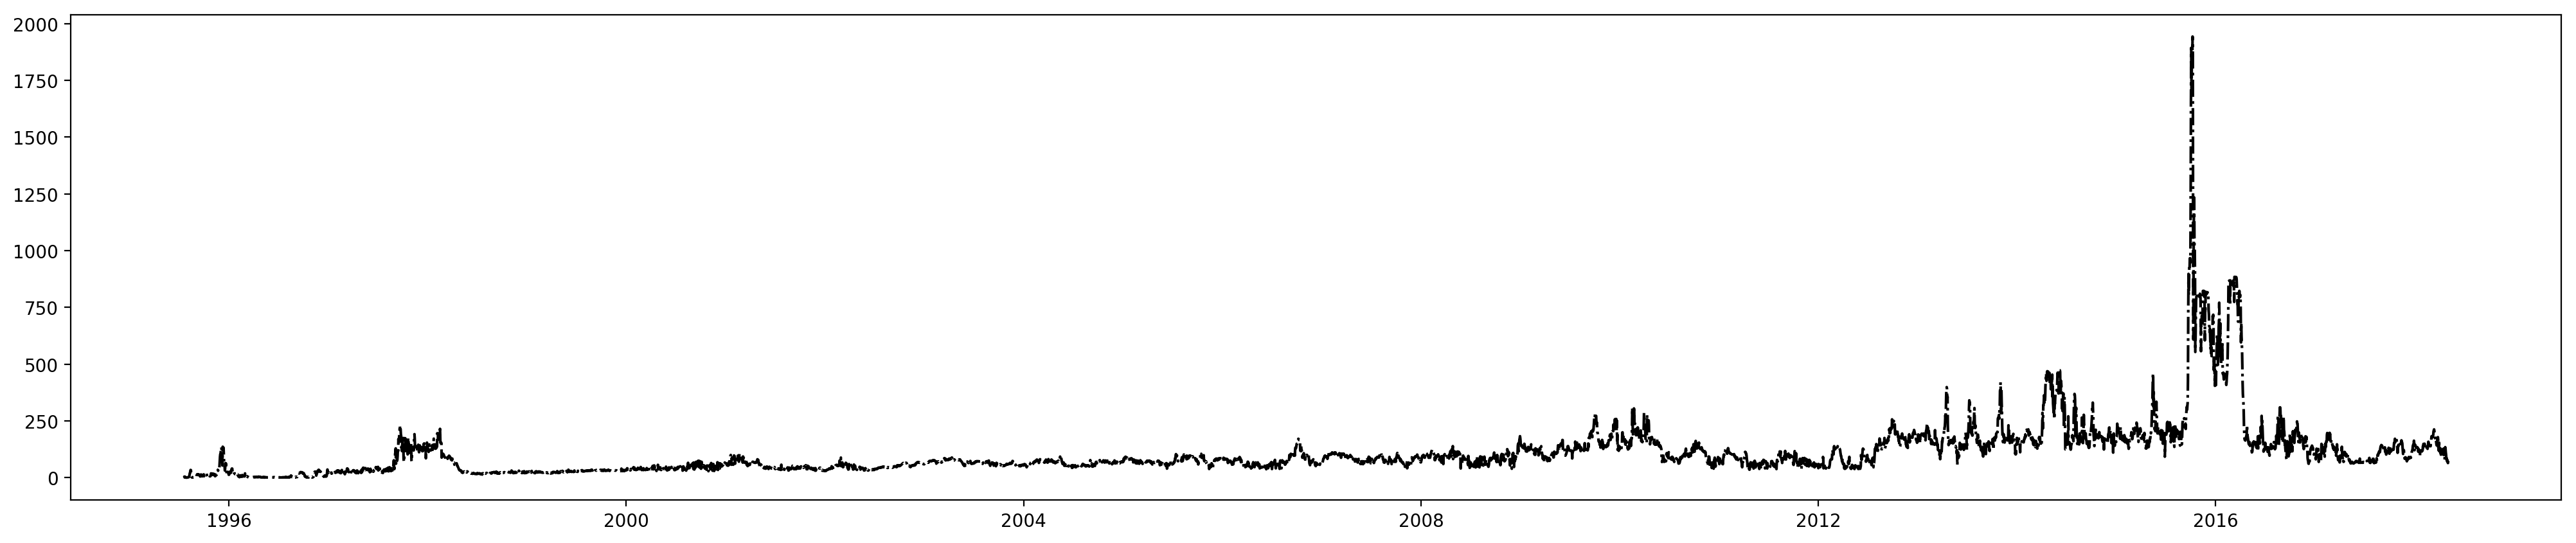

In [11]:
figure(num=None, figsize=(25,5), dpi=200, facecolor='w', edgecolor='k')
plt.plot(serie["Fecha"], serie.iloc[:,1],'k-.')
plt.show()

In [16]:
serie = serie.dropna() 

In [17]:
serie.reset_index(drop=True, inplace=True)

In [18]:
serie.columns = ["fecha","price"]

### feature scaling

In [19]:
sc = MinMaxScaler(feature_range = (0, 1))

d = sc.fit_transform(serie["price"].values.reshape(-1,1)).reshape(-1,)

### Construcción de modelo de pronostico adaptativo sin transformaciones

In [20]:
dias_a_predecir = 24*7

In [21]:
tf.enable_eager_execution()

In [22]:
class Model(object):
    def __init__(self, L):        
        # Inicio mi vector de pesos
        self.w = tf.Variable([0.0] * (L))

    def __call__(self, x):
        # Añado bias a mi entrada y lo múltiplico por mis pesos para obtener el pronóstico
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

    def fit(self, mu, x, y_desired):
        # multiplico por mis pesos
        y_pred = self(x)
        # saco mi error
        e = y_desired - y_pred
        # BIAS
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        # gradient...
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))
        
        

### Calibración número de retardos adecueado

In [23]:
# Nro de retardos a probar
retardos = [2,3,4,5,6,7,8,10]

In [24]:
def tuning_retardos(retardos,d):
    
    resultado_retardos = []

    for i in range(len(retardos)):

        L = retardos[i]

        model = Model(L)

        y_pred = np.empty(len(d))
        y_pred[:] = np.nan

        for t in range(L, len(d)):
            x = d[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=0.05, x=x, y_desired=d[t])

        resultado_retardos.append([d[-(dias_a_predecir):],y_pred[-(dias_a_predecir):]])
        
    return resultado_retardos

resultado_retardos = tuning_retardos(retardos,d)

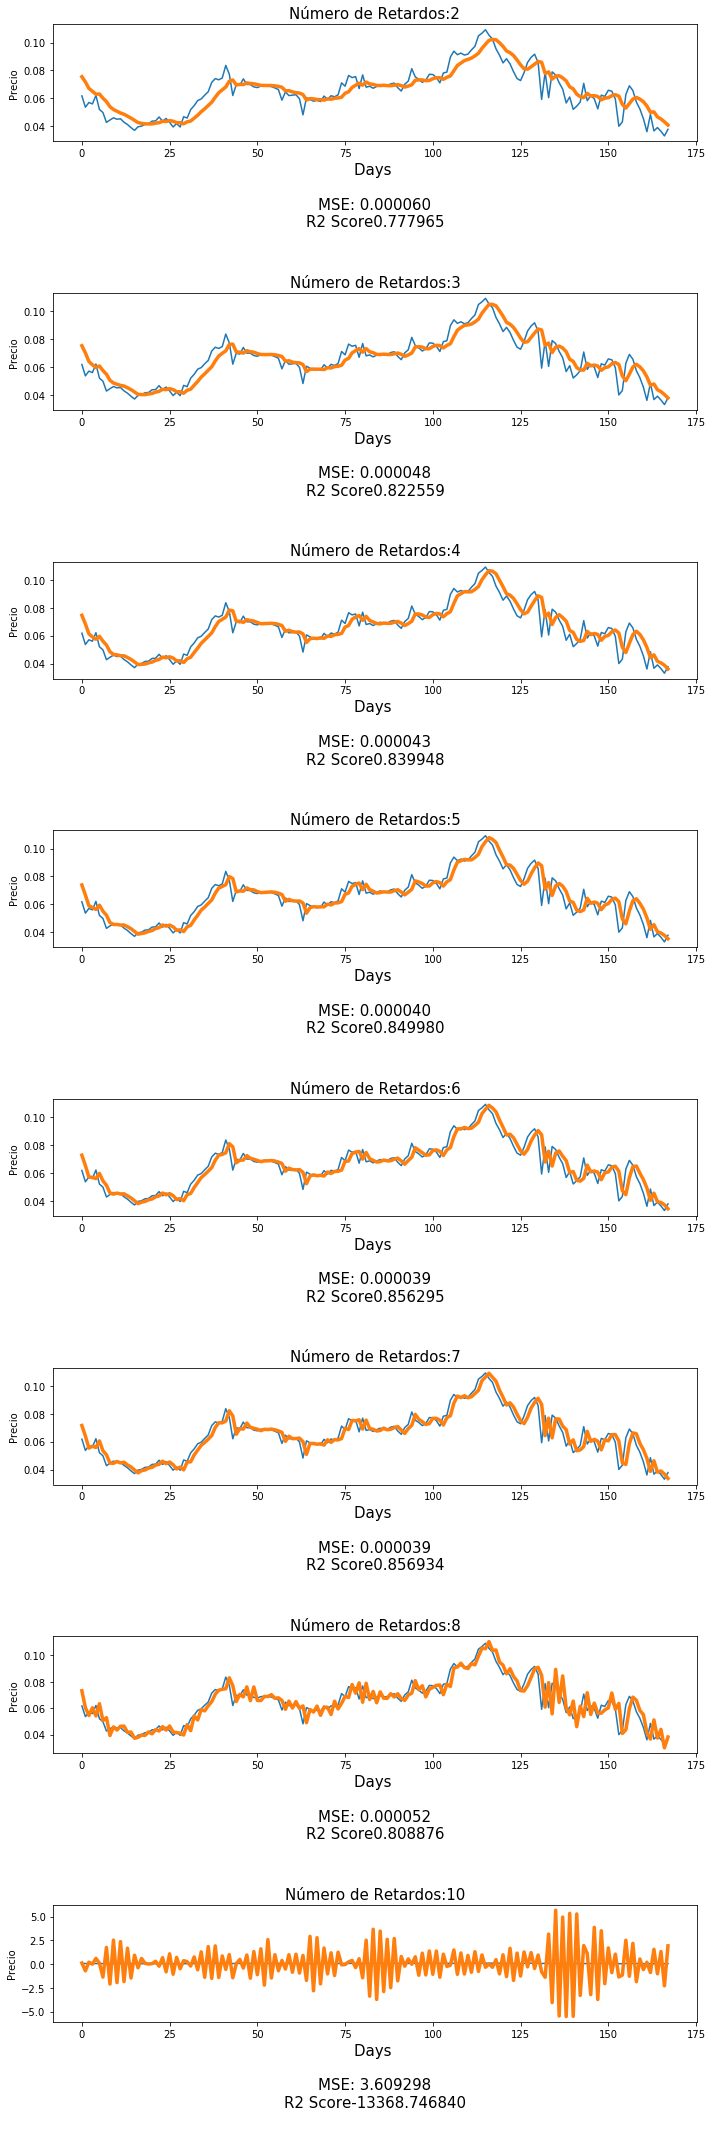

In [37]:
fig, axes = plt.subplots(nrows=8, ncols=1,figsize=(10,30))

count = 0

for ax in axes:    

    titulo = str("Número de retardos:"+str(retardos[count])) 

    ax.plot(resultado_retardos[count][0],label = 'Real')
    ax.plot(resultado_retardos[count][1],label = 'Predicted',linewidth=3.5)

    ax.set_xlabel('Days \n \n'+                     
                  str('MSE: ' + '{:f}'.format(metrics.mean_squared_error(resultado_retardos[count][0],resultado_retardos[count][1])))+'\n'+
                  str('R2 Score' + '{:f}'.format(r2_score(resultado_retardos[count][0],resultado_retardos[count][1]))+'\n \n'),fontsize=15) 

    ax.set_ylabel('Precio')
    ax.set_title(str('Número de Retardos:'+str(retardos[count])),fontsize=15)

    fig    
    plt.tight_layout()

    count+=1

### Calibración tasa de aprendizaje

In [29]:
lr = [0.1, 0.01,0.001,0.0001]

In [37]:
resultado_lr = []

for i in range(len(lr)):
    
    L = 7

    model = Model(L)

    y_pred = np.empty(len(d))
    y_pred[:] = np.nan

    for t in range(L, len(d)):
        x = d[t-L:t]
        y_pred[t] = model(x)
        model.fit(mu=lr[i], x=x, y_desired=d[t])

    resultado_lr.append([d[-(dias_a_predecir):],y_pred[-(dias_a_predecir):]])

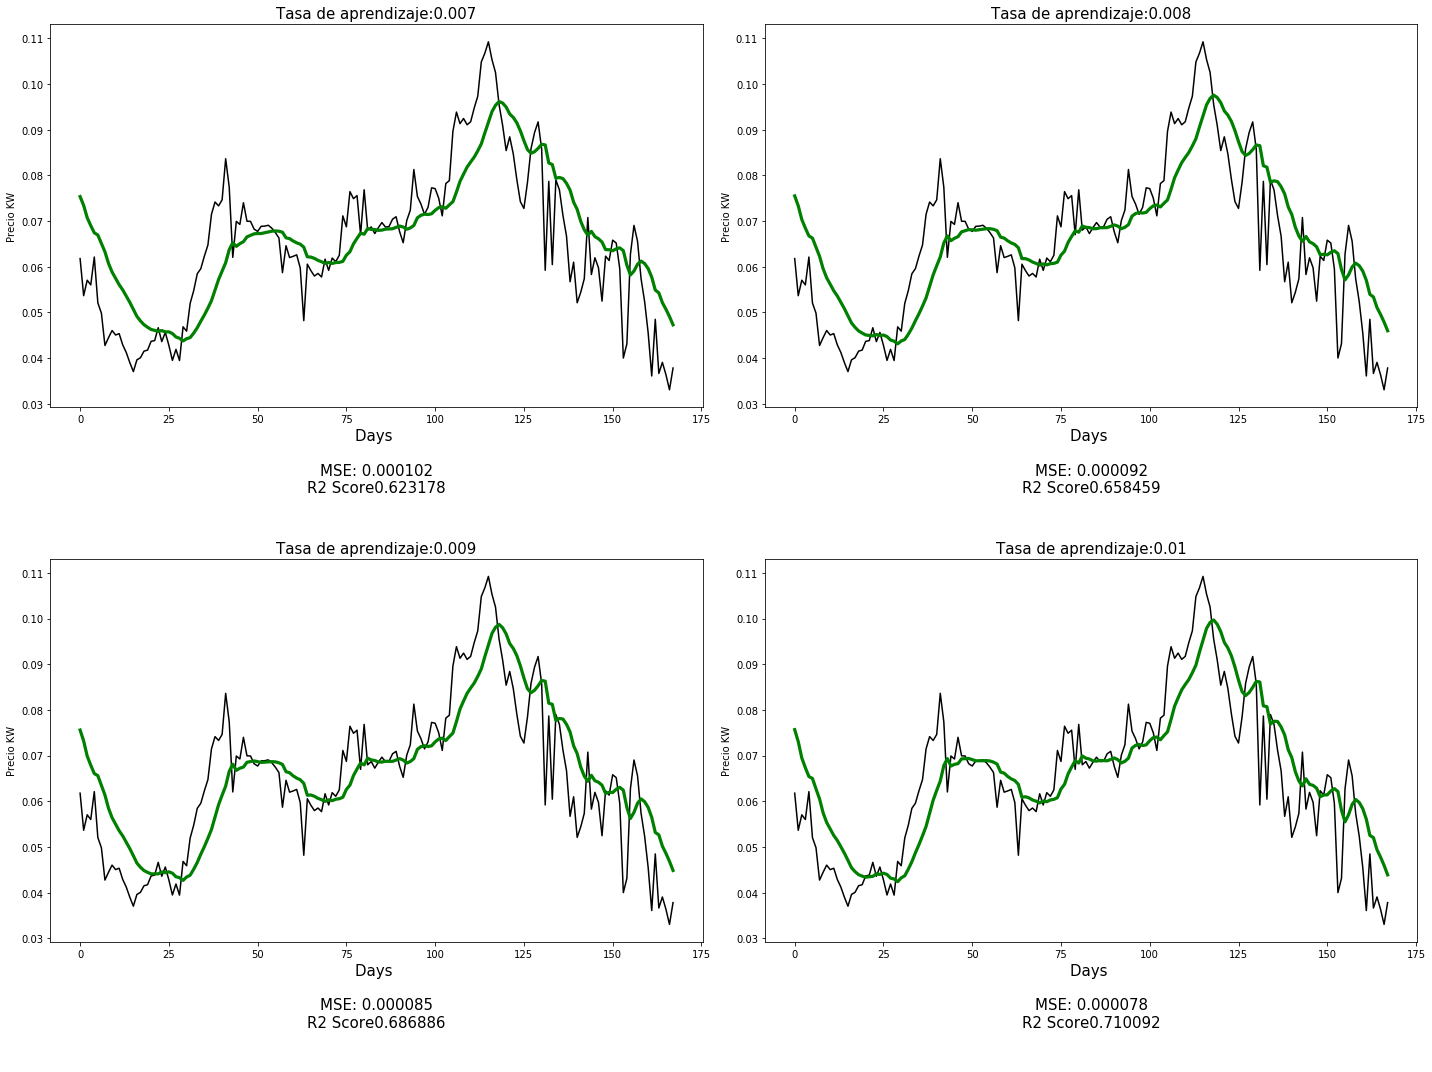

In [38]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(20,15))

count = 0
    
for ax in axes:    

    titulo = str("Número de retardos:"+str(retardos[count])) 

    ax.plot(resultado_lr[count][0],color = 'black',label = 'Real')
    ax.plot(resultado_lr[count][1],color = 'green',label = 'Predicted',linewidth=3.2)

    ax.set_xlabel('Days \n \n'+                     
                  str('MSE: ' + '{:f}'.format(metrics.mean_squared_error(resultado_lr[count][0],resultado_lr[count][1])))+'\n'+
                  str('R2 Score' + '{:f}'.format(r2_score(resultado_lr[count][0],resultado_lr[count][1]))+'\n \n'),fontsize=15) 

    ax.set_ylabel('Precio KW')
    ax.set_title(str('Tasa de aprendizaje:'+str(lr[count])),fontsize=15)

    fig    
    plt.tight_layout()

    count+=1


#### Conociendo que rango es el adecuado se hace de nuevo un grid con valores cercanos a 0.01 para obtener un valor más preciso que un R2 de .67

In [33]:
lr = [0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05,0.06,0.07]

In [34]:
def tuning_lr(lr,d):
    
    resultado_lr = []

    for i in range(len(lr)):    
        L = 6

        model = Model(L)

        y_pred = np.empty(len(d))
        y_pred[:] = np.nan

        for t in range(L, len(d)):
            x = d[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=lr[i], x=x, y_desired=d[t])

        resultado_lr.append([d[-(dias_a_predecir):],y_pred[-(dias_a_predecir):]])
        
    return resultado_lr

resultado_lr = tuning_lr(lr,d)

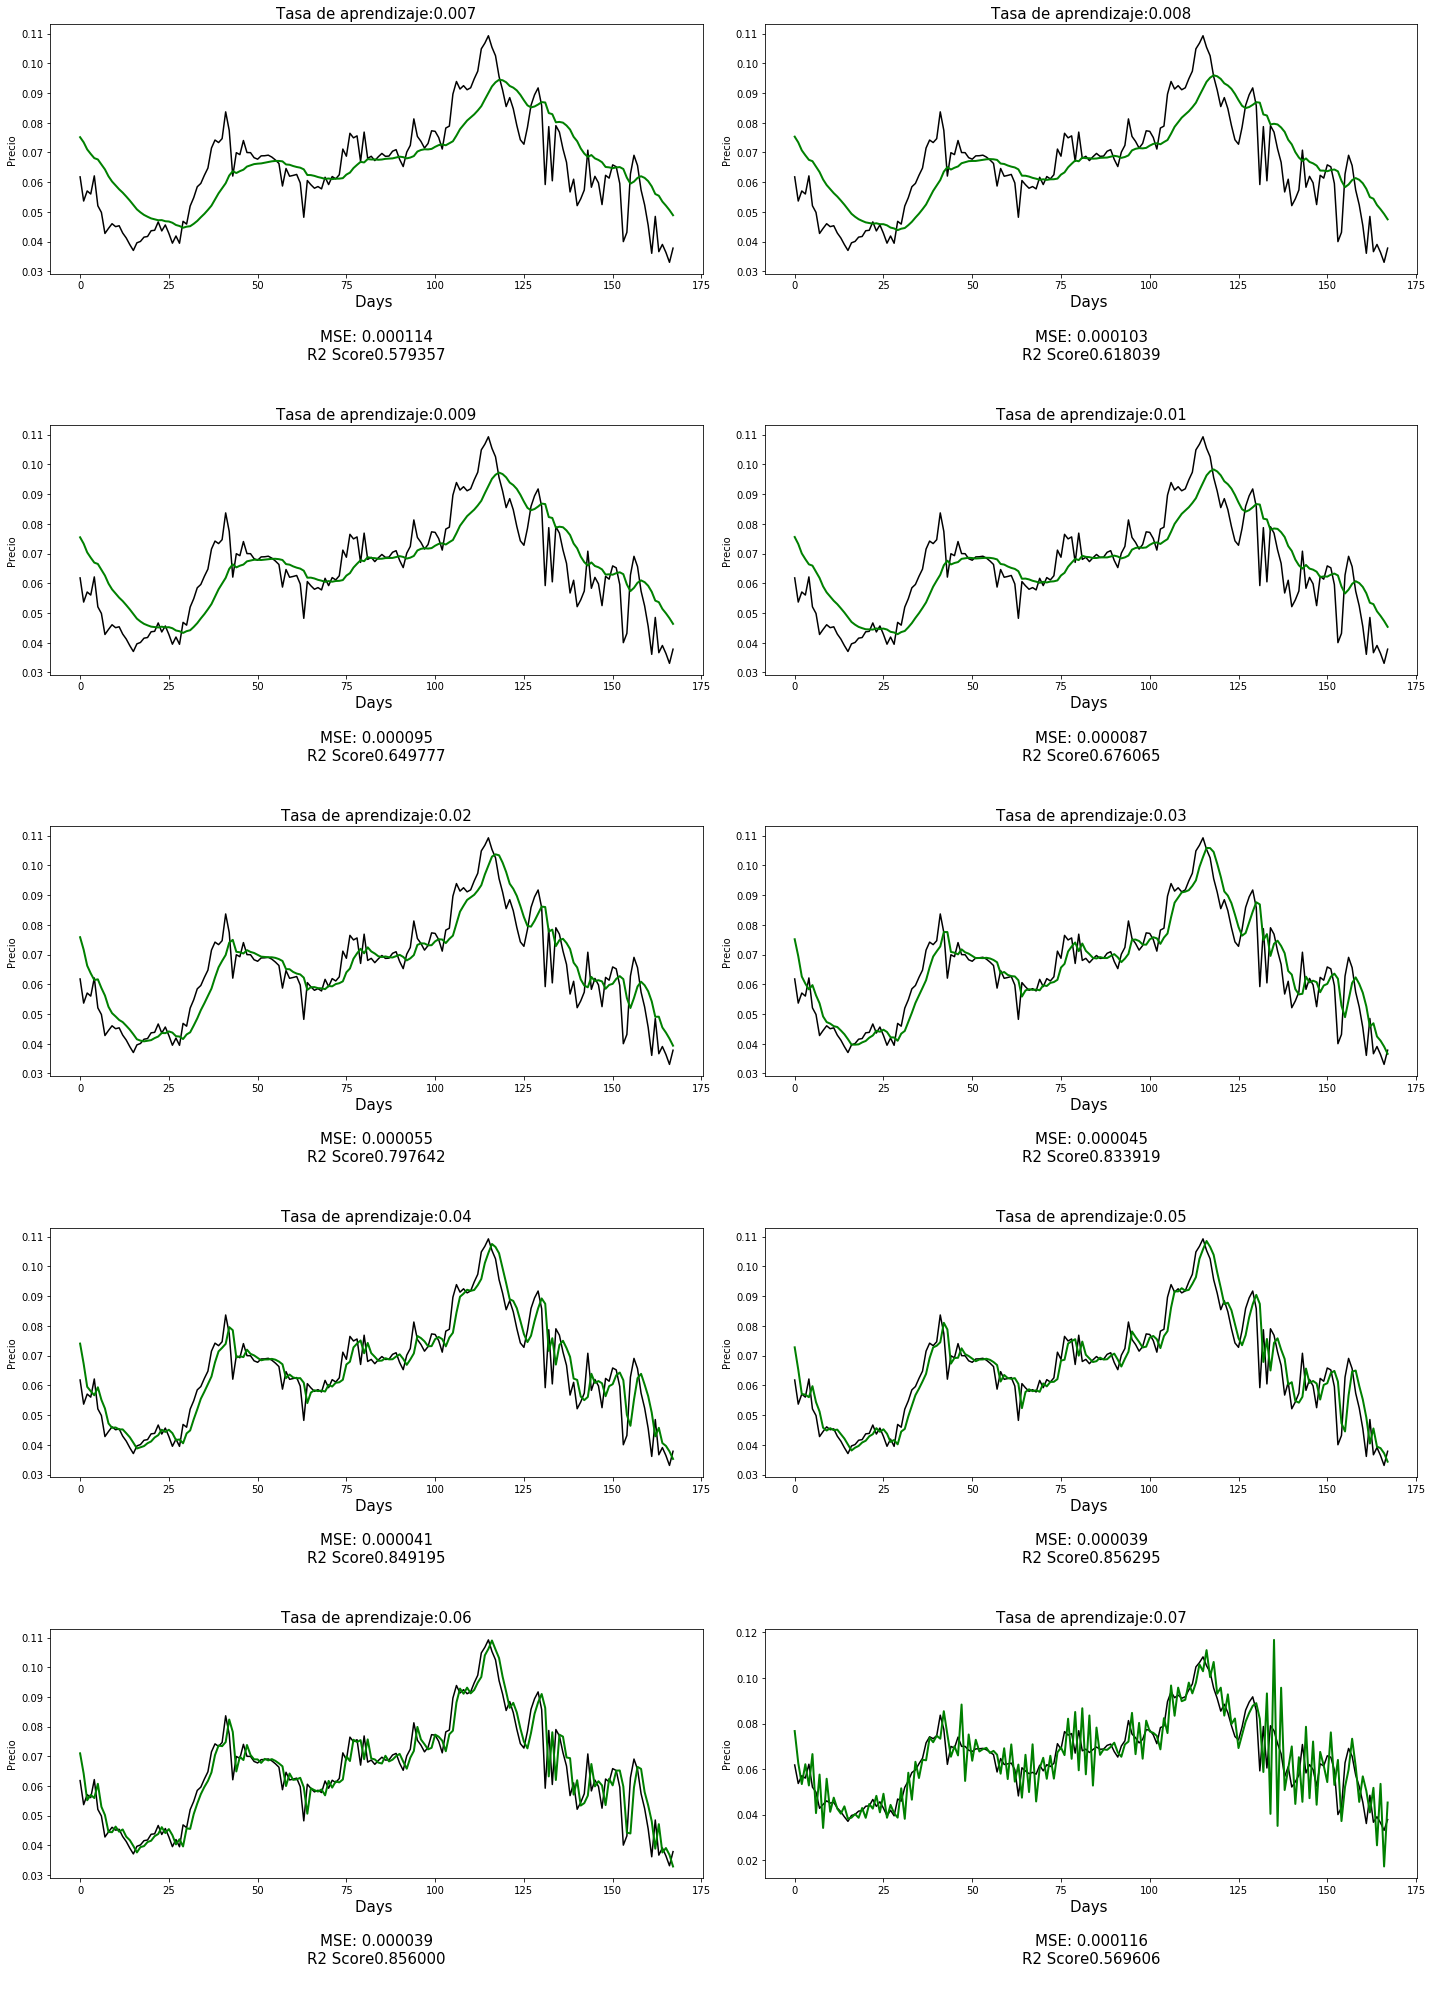

In [36]:
fig, axes = plt.subplots(nrows=10, ncols=1,figsize=(20,28))

count = 0
for axes in fila:

    titulo = str("Tasa de aprendizaje:"+str(lr[count])) 

    ax.plot(resultado_lr[count][0],color = 'black',label = 'Real ')
    ax.plot(resultado_lr[count][1],color = 'green',label = 'Predicted',linewidth=2.0)

    ax.set_xlabel('Days \n \n'+                     
                  str('MSE: ' + '{:f}'.format(metrics.mean_squared_error(resultado_lr[count][0],resultado_lr[count][1])))+'\n'+
                  str('R2 Score' + '{:f}'.format(r2_score(resultado_lr[count][0],resultado_lr[count][1]))+'\n \n'),fontsize=15) 

    ax.set_ylabel('Precio')
    ax.set_title(str('Tasa de aprendizaje:'+str(lr[count])),fontsize=15)

    fig    
    plt.tight_layout()

    count+=1


#### La tasa de aprendizaje más adecuado para 7 retardos es 0.05

## Modelo sin transformación con los parámetros óptimos

In [39]:
def graficar_modelo(real,pred):
    """
    Función para gráficar el resultado y métricas de los modelos
    """
    figure(figsize=(12,6))
    plt.plot(real, label = 'Real')
    plt.plot(pred, label = 'Predicho')
    plt.xlabel('Horas/Día \n \n'+
              'R2: '+str(r2_score(real,pred))+'\n \n'
              'MSE: '+str(metrics.mean_squared_error(real, pred))
              )
    plt.ylabel('Precio')
    plt.legend()
    return plt.show()

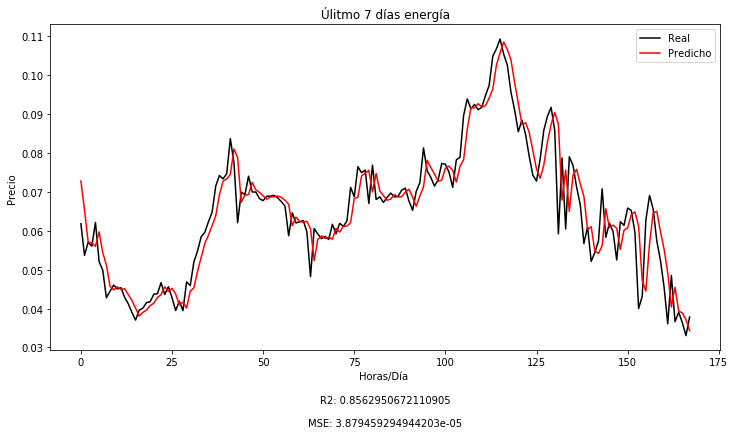

In [40]:
def adaline(L,lr,d):
    L = L

    model = Model(L)

    y_pred = np.empty(len(d))
    y_pred[:] = np.nan

    for t in range(L, len(d)):
        x = d[t-L:t]
        y_pred[t] = model(x)
        model.fit(mu=lr, x=x, y_desired=d[t])
    
    return [d[-(dias_a_predecir):],y_pred[-(dias_a_predecir):]]
    
modelo_sin_transf = adaline(6,0.05,d)

graficar_modelo(modelo_sin_transf[0],modelo_sin_transf[1],"Úlitmo 7 días energía")

### Selección de transformación adecuada para el modelo

Se va a comparar el resultado del modelo anterior aplicando las transformaciones
 
 * Raiz Cuadrada
 * Raíz Cúbica

In [41]:
def evaluacion(resultados,parametros):    
    """
    Función para evaluar el resultado del tuning de parámetros (retarodos, lr...)
    """
    metricas = []
    
    for i in range(len(resultados)):
        
        real,pred = resultados[i][0],resultados[i][1]
        
        r2 = r2_score(real,pred)
        mse = metrics.mean_squared_error(real, pred)
        
        metricas.append([r2,mse])
     
    df = pd.DataFrame(metricas,parametros)
    
    return df.sort_values(by=[0],ascending=False).iloc[0]

### Raíz Cuadrada

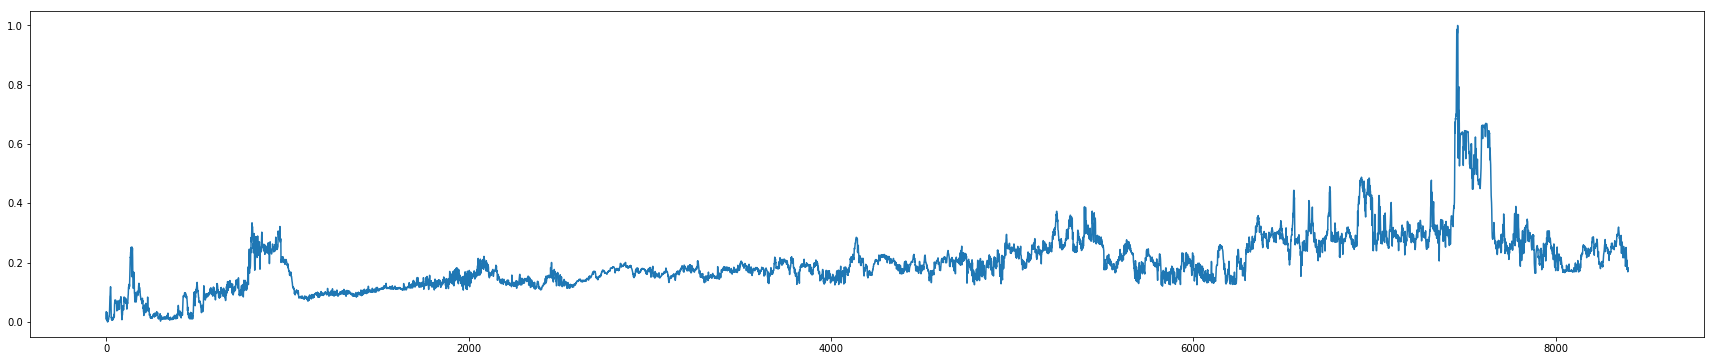

In [42]:
serie_sqrt = sc.fit_transform(serie["price"].apply(np.sqrt).values.reshape(-1,1)).reshape(-1,)
figure(figsize=(30,6))
plt.plot(serie_sqrt)

#### Tuninig Retardos

In [43]:
## evaluo los resultados de la calibración de los retardos para la transformación de la raíz cuadrada 
resultado_retardos_sqrt = tuning_retardos(retardos,serie_sqrt)

In [44]:
## Obtengo el mejor parámetro
mejor_retardo_sqrt = evaluacion(resultado_retardos_sqrt,retardos)

In [45]:
## Un retardo de 5 registros 
mejor_retardo_sqrt

0    0.849737
1    0.000163
Name: 5, dtype: float64

#### Tuning LR

In [46]:
## evaluo los resultados de la calibración de la LR para la transformación de la raíz cuadrada 
resultado_lr_sqrt = tuning_lr(lr,serie_sqrt)

In [47]:
## Obtengo el mejor parámetro
mejor_lr_sqrt = evaluacion(resultado_lr_sqrt,lr)

In [48]:
## Una tasa de aprendizaje de 0.04
mejor_lr_sqrt

0    0.852226
1    0.000160
Name: 0.04, dtype: float64

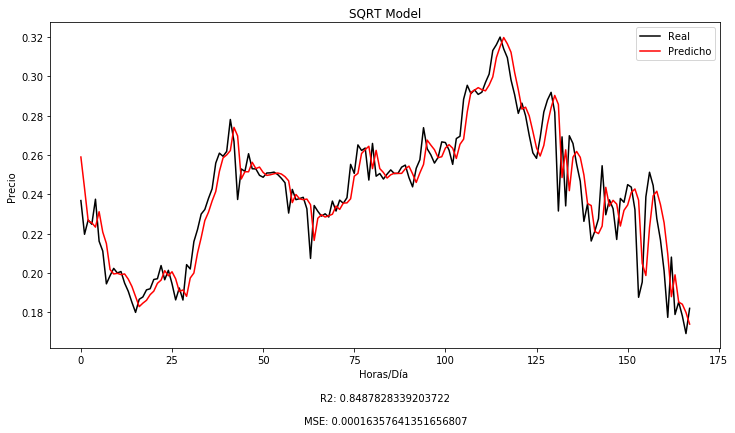

In [49]:
modelo_sqrt = adaline(5,0.04,serie_sqrt)

graficar_modelo(modelo_sqrt[0],modelo_sqrt[1],"SQRT Model")

### Raíz Cúbica

In [50]:
serie_cbrt = sc.fit_transform(np.array(serie["price"].apply(np.cbrt).values.reshape(-1,1))).reshape(-1,)

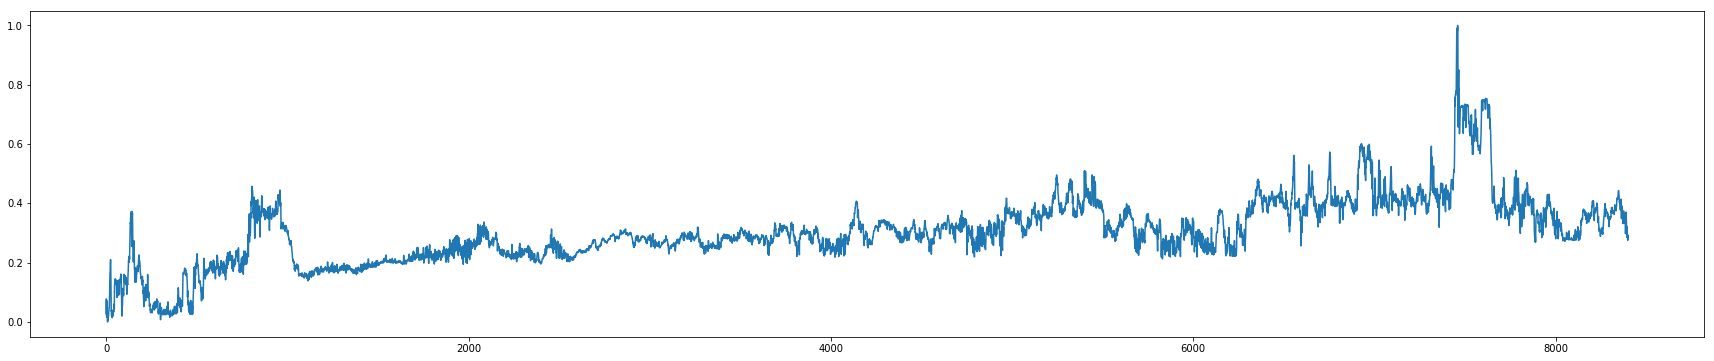

In [51]:
figure(figsize=(30,6))
plt.plot(serie_cbrt)

#### Tuninig Retardos

In [52]:
## evaluo los resultados de la calibración de los retardos para la transformación de la raíz cúbica
resultado_retardos_cbrt = tuning_retardos(retardos,serie_cbrt)

In [53]:
resultado_retardos_cbrt = resultado_retardos_cbrt[0:6]

In [54]:
## Obtengo el mejor parámetro
mejor_retardo_cbrt = evaluacion(resultado_retardos_cbrt,retardos[0:6])

In [55]:
## Un retardo de 5 registros 
mejor_retardo_sqrt

0    0.849737
1    0.000163
Name: 5, dtype: float64

#### Tuning LR

In [56]:
## evaluo los resultados de la calibración de la LR para la transformación de la raíz cúbica
resultado_lr_cbrt = tuning_lr(lr,serie_cbrt)

In [57]:
## Obtengo el mejor parámetro
mejor_lr_cbrt = evaluacion(resultado_lr_cbrt,lr)

In [58]:
## Una tasa de aprendizaje de 0.03
mejor_lr_cbrt

0    0.849797
1    0.000201
Name: 0.03, dtype: float64

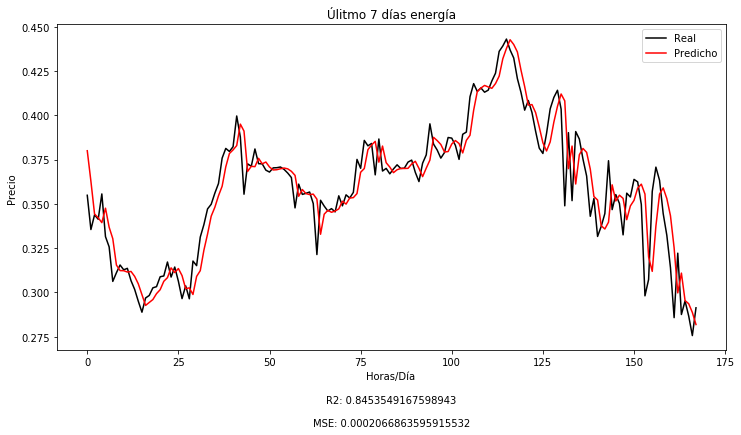

In [59]:
modelo_cbrt = adaline(5,0.03,serie_cbrt)

graficar_modelo(modelo_cbrt[0],modelo_cbrt[1],"Úlitmo 7 días energía")

**Resultados de los modelos:**
    
    Sin transformación: 
        * MSE          0.8562      
        * R2       0.00005

    Raíz Cuadrada
         * MSE         0.8487      
         * R2       0.0001

    Raíz Cúbica
         * MSE         0.8453      
         * R2       0.0002